![Plain flap sketch](https://cdn.boldmethod.com/images/learn-to-fly/aircraft-systems/4-types-of-flaps/diagram-plain.jpg)

In this notebook we will study plain flaps.

---

In [345]:
from collections import defaultdict
from functools import partial

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import viiflow as vf
import viiflowtools.vf_plots as vfp
import viiflowtools.vf_tools as vft
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.stats import linregress

%matplotlib notebook
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams["figure.figsize"] = [10, 7]  # Make plots bigger than default

import logging

logging.getLogger().setLevel(logging.INFO)

In [2]:
savefig = partial(plt.savefig, dpi=300, transparent=True, bbox_inches="tight")

In [3]:
# Read and panel airfoil data
_main = vft.read_selig("NLR7301MainECARP.dat")

In [4]:
N_MAIN = 200
N_CHEBY = 100

In [5]:
MAIN = vft.repanel(_main, N_MAIN)[:, ::-1]

---

In [6]:
ROUND_DECIMALS = 8

main_df = pd.DataFrame(MAIN.T, columns = ["X", "Y"])
main_df = main_df.round(ROUND_DECIMALS)

# Split into upper and lower surfaces
min_x_idx = main_df.X.idxmin()

upper = main_df.loc[:min_x_idx].set_index("X")
lower = main_df.loc[min_x_idx:].set_index("X")

max_x_upper = upper.index.max()
max_x_lower = lower.index.max()

max_x = min([max_x_upper, max_x_lower])
min_x = upper.index.min()

In [7]:
def create_chebyshev_nodes(a, b, N):
    """Create a Chebyshev node distribution to accumulate points
    near the LE and the TE, where curvature changes become important.
    
    Parameters
    ----------
    a : float, interval start
    b : float, interval end
    N : int
    
    Returns
    -------
    nodes : numpy.array
    """

    func = lambda i: np.cos(np.pi * float(2 * i) / (2 * N))
    nodes = np.array(list(map(func, range(N+1))))
    
    mid_point = 0.5 * (a + b)
    scale = 0.5 * (b - a)
    
    nodes *= scale
    nodes += mid_point
    
    return nodes

In [8]:
x_space = create_chebyshev_nodes(a=min_x, b=max_x, N=N_CHEBY)
x_space = np.round(x_space, ROUND_DECIMALS)
x_space = pd.Index(x_space)

index_upper = x_space.union(upper.index).sort_values()
index_lower = x_space.union(lower.index).sort_values()

# Reindex upper and lower surface to same index
upper_common = (
    upper.reindex(index_upper)
    .interpolate(method="index")
    .reindex(x_space)
    .sort_index(ascending=False)
)
lower_common = (
    lower.reindex(index_lower)
    .interpolate(method="index")
    .reindex(x_space)
    .sort_index(ascending=True)
)

In [9]:
# Create mean line
MEAN_LINE = (upper_common["Y"] + lower_common["Y"]) / 2

In [10]:
# Compute thickness-to-chord results
thickness = (upper_common["Y"] - lower_common["Y"])
T_C = thickness.max()

In [11]:
# Create coordinates table with upper and lowre
main_common = pd.concat(
    [upper_common.reset_index(), lower_common.reset_index()], axis=0
)
main_common.columns = ["X", "Y_interp"]
main_common = main_common.reset_index(drop=True)
main_common = main_common.drop_duplicates()

# Update airfoil coordinates to rotate TE
MAIN = main_common.values.T

<IPython.core.display.Javascript object>


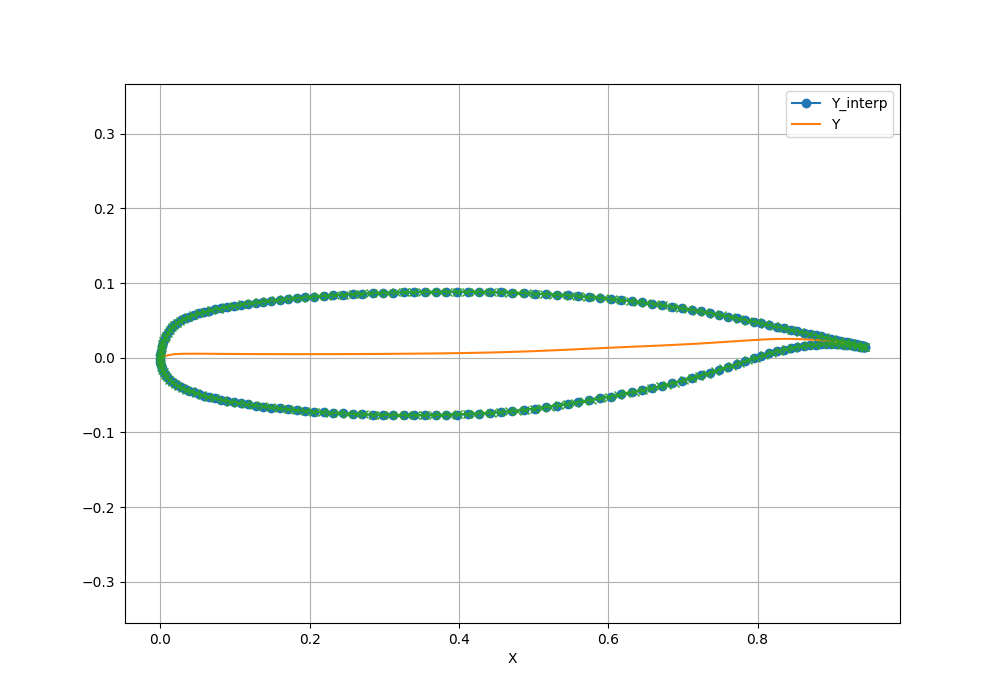

(-0.04722454250000001, 0.9908606925000001, -0.085347613, 0.096652733)

In [12]:
ax = main_common.set_index("X").plot(marker="o")
MEAN_LINE.plot(ax=ax)
main_df.set_index("X").plot(ax=ax, grid=True, marker="x")
plt.axis("equal")

In [13]:
def rotate_around_center(points, deg, center):
    """Rotate points around a center in space.

    Parameters
    ----------
    points : np.array 2xN
    deg : float
    center : np.array 2x1

    Returns
    -------
    rotated : np.array 2xN
    """
    rad = np.deg2rad(deg)
    c, s = np.cos(rad), np.sin(rad)
    A = np.array([[c, s], [-s, c]])

    # The following transposing is done, because numpy subtracts 1x2 arrays from a Nx2 array,
    # but not 2x1 arrays form an 2xN array.

    x = points
    rotated = ((A @ ((x.T - center.T).T)).T + center.T).T

    return rotated

In [14]:
def smooth(x, window_len=11, window="hanning"):
    """Smooth the data using a window with requested size.
    
    Parameters
    ----------
    x : numpy.array 
        Input signal
    window_len : int
        Dimension of the smoothing window; should be an odd integer
    window: str
        Window type from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
        "flat" window will produce a moving average smoothing.

    Returns
    -------
    y : numpy.array
        Smoothed signal
    
    Example
    -------
    >> t=linspace(-2,2,0.1)
    >> x=sin(t)+randn(len(t))*0.1
    >> y=smooth(x)

    Notes
    -----    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    See also
    --------
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
    
    Source
    ------
    https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    """

    if x.ndim != 1:
        raise ValueError("Smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if not window in ["flat", "hanning", "hamming", "bartlett", "blackman"]:
        raise ValueError(
            f"Window {window} is not one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        )

    s = np.r_[x[window_len - 1 : 0 : -1], x, x[-2 : -window_len - 1 : -1]]

    if window == "flat":  # moving average
        w = np.ones(window_len, "d")
    else:
        w = eval("np." + window + "(window_len)")

    y = np.convolve(w / w.sum(), s, mode="valid")
    
    # Return same dimensions as the original signal
    y = y[(window_len//2-1):-(window_len//2)]

    return y

In [15]:
def create_plain_flap(coordinates, hinge, delta, smooth_result=True):
    """Create a plain flap by deflecting the points beyond and w.r.t. 
    to a hinge location.

    Parameters
    ----------
    coordinates : numpy.array
        Size 2xN 
    hinge : float
    delta : float
    smooth : bool
        Perform smoothing, by default True.
        
    Returns
    -------
    main_flap : numpy.array
        Size 2xN
        
    Notes
    -----
    The hinge point is located in the mean line, 
    stored in the MEAN_LINE variable.
    """

    mask = MEAN_LINE.index >= hinge

    center_x = MEAN_LINE.index[mask][0]
    center_y = MEAN_LINE.loc[center_x]

    CENTER = np.r_[center_x, center_y]

    # Get index locations to select points to rotate
    _until, _from = np.argwhere(coordinates[0, :] == center_x).flatten()
    _until += 1  # Due to slicing criteria in numpy

    # Rotate airfoil
    _rotate = partial(rotate_around_center, deg=delta, center=CENTER)

    main_flap = coordinates.copy()

    main_flap[:, :_until] = _rotate(points=coordinates[:, :_until])
    main_flap[:, _from:] = _rotate(points=coordinates[:, _from:])

    # Smooth out edges in the first rotation node
    if smooth_result == True:
        main_flap[1, :] = smooth(main_flap[1, :], window_len=10, window="hanning")

    return main_flap, CENTER

In [16]:
# This angle seems to present an horizontal airfoil
DELTAS = [2.5, 5, 7.5, 10, 12.5, 15, 20]
HINGE = 0.7

<IPython.core.display.Javascript object>


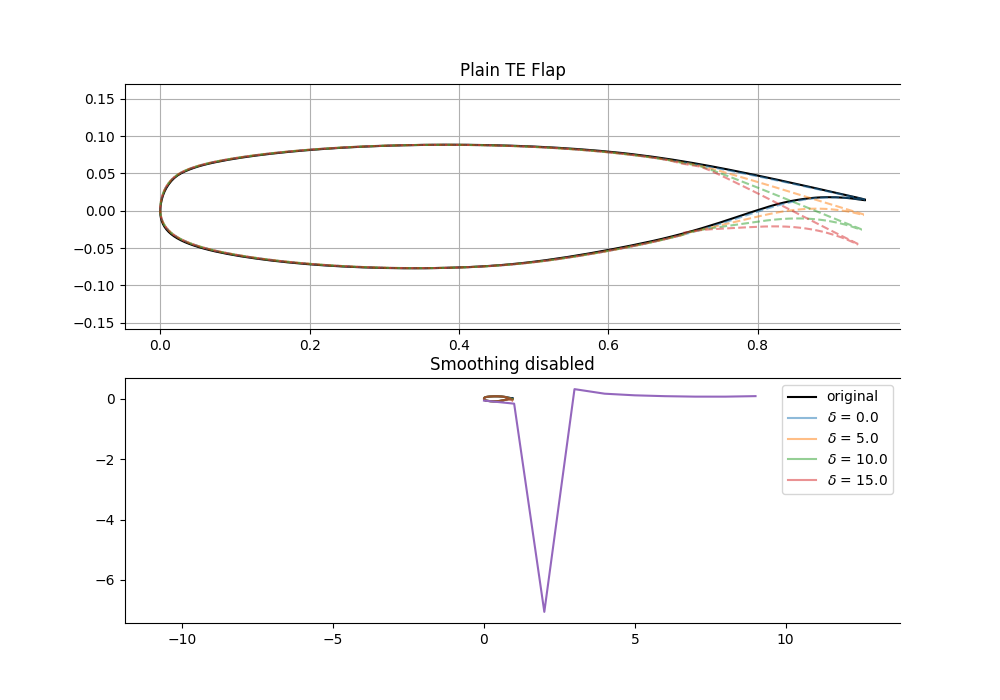

In [313]:
fig, axes = plt.subplots(2, 1)

smooth_airfoil = True
ax = axes[0]

plot_flap = partial(ax.plot, linestyle="--", alpha=0.5)

# To accomodate text on the plot
ax.spines["right"].set_visible(False)
ax.plot(MAIN[0, :], MAIN[1, :], "-k", label="original")

_deltas = DELTAS[::2]

for delta in _deltas:

    main_flap, hinge = create_plain_flap(
        coordinates=MAIN, hinge=HINGE, delta=delta, smooth_result=smooth_airfoil
    )

    # Plot geometry
    plot_flap(main_flap[0, :], main_flap[1, :])

ax.set_title(f"Plain TE Flap")
ax.axis("equal")
ax.grid()

smooth_airfoil = False
ax = axes[1]

plot_flap = partial(ax.plot, linestyle="-", alpha=0.5)

# To accomodate text on the plot
ax.spines["right"].set_visible(False)
ax.plot(MAIN[0, :], MAIN[1, :], "-k", label="original")

for delta in _deltas:

    main_flap, hinge = create_plain_flap(
        coordinates=MAIN, hinge=HINGE, delta=delta, smooth_result=smooth_airfoil
    )

    # Plot geometry
    plot_flap(main_flap[0, :], main_flap[1, :], label = f"$\delta$ = {delta}")

ax.set_title(f"Smoothing disabled")
ax.axis("equal")
ax.set_xlim(left = 0.9, right = None)
ax.legend(loc ="best", ncol=1)
ax.grid()

savefig(fname="Plain_flap_sketch.png")

## Viiflow Parameters
All calculations have been performed with a Reynolds Number of 2.51E6 and a Mach Number of 0 or 0.185 using a Karman-Tsien correction for the pressure and lift. A critical amplification factor of 8 was used, while 11.2 seems to be recommended for the Delft low-speed wind tunnel[5].
However, the lower value agrees better with the observed transition (see the pressure distributions below).

In [18]:
def compute_flap_load_ratio(panel, return_error=False, hinge=None):
    """Integrate the pressure distribution on each airfoil to
    obtain the load distribution w.r.t. to the overall lift coefficient.

    Parameters
    ----------
    panel : viiflow.panelCpl.panel_problem.PanelProblem
    return_error : bool
        Compute error between Cl computed via Cp integration and
        actual viiflow computation of Cl.
    hinge : float, by default None

    Returns
    -------
    load_ratio : float
    """

    # Compute each element load contribution
    cls = integrate_cp_distribution(panel=panel, hinge=hinge)

    if hinge is None:

        load_ratio = 0.0
        cl = cls

    else:

        # Compute overall lift force
        cl = cls[0] + cls[1]

        # Compute load ratio
        load_ratio = cls[1] / cl

    # Compute error in cl computation
    computed_cl = panel.CL
    error = (computed_cl - cl) / computed_cl

    if return_error == True:
        result = (load_ratio, error)
    else:
        result = load_ratio

    return result


def integrate_cp_distribution(panel, hinge=None):
    """Integrate cp distributions.

    Parameters
    ----------
    panel : viiflow.panelCpl.panel_problem.PanelProblem
    hinge : float

    Returns
    -------
    float or dict
    """

    foils = panel.foils
    number_foils = len(foils)

    if number_foils == 1:

        _data = np.vstack([panel.foils[0].X[0, :], panel.cp]).T
        cp_df = pd.DataFrame(_data, columns=["X", "cp"])

        cl = _integrate_cp(cp_flatten=cp_df, hinge=hinge)

    elif number_foils == 2:

        cp_ranges = [
            range(0, panel.foils[0].N),
            range(panel.foils[0].N, panel.foils[0].N + panel.foils[1].N),
        ]

        cl = dict()
        for foil_idx in range(2):

            _indices = cp_ranges[foil_idx]
            _data = np.vstack([panel.foils[foil_idx].X[0, :], panel.cp[_indices]]).T
            cp_df = pd.DataFrame(_data, columns=["X", "cp"])

            _cl = _integrate_cp(cp_flatten=cp_df)

            cl[foil_idx] = _cl

    else:
        raise NotImplementedError("")

    return cl


def _integrate_cp(cp_flatten, hinge=None):
    """Integrate Cp distribution.

    Parameters
    ----------
    cp_flatten : pandas.DataFrame
        Two columns, X and Cp.
    hinge : float

    Returns
    -------
    cl : float

    If hinge is given

    cl_airfoil
    cl_flap
    """

    cp_flatten = cp_flatten.round(ROUND_DECIMALS)

    # Split into upper and lower surfaces
    min_x_idx = cp_flatten.X.idxmin()

    upper = cp_flatten.loc[:min_x_idx].set_index("X")
    lower = cp_flatten.loc[min_x_idx:].set_index("X")

    # Create integration space
    max_x_upper = upper.index.max()
    max_x_lower = lower.index.max()

    max_x = min([max_x_upper, max_x_lower])
    min_x = upper.index.min()

    x_space = create_chebyshev_nodes(a=min_x, b=max_x, N=N_CHEBY)
    x_space = np.round(x_space, ROUND_DECIMALS)
    x_space = pd.Index(x_space)

    # Reindex upper and lower surface to same index
    index_upper = x_space.union(upper.index).sort_values()
    index_lower = x_space.union(lower.index).sort_values()

    upper_common = (
        upper.reindex(index_upper)
        .interpolate(method="index")
        .reindex(x_space)
        .sort_index(ascending=False)
    ).squeeze()

    lower_common = (
        lower.reindex(index_lower)
        .interpolate(method="index")
        .reindex(x_space)
        .sort_index(ascending=True)
    ).squeeze()

    upper_common.name = "cp_upper"
    lower_common.name = "cp_lower"

    # Compute difference and integrate
    cp = pd.concat([upper_common, lower_common], axis=1)

    cp["diff"] = cp["cp_upper"] - cp["cp_lower"]

    # Split integration values if a hinge is present
    if hinge is not None:

        # Select nodes to integrate
        mask_flap = cp.index >= hinge
        mask_airfoil = np.logical_not(mask_flap)

        cp_diff_airfoil = cp.loc[mask_airfoil, "diff"]
        cp_diff_flap = cp.loc[mask_flap, "diff"]

        cl_airfoil = simps(y=-cp_diff_airfoil, x=cp_diff_airfoil.index)
        cl_flap = simps(y=-cp_diff_flap, x=cp_diff_flap.index)

        result = cl_airfoil, cl_flap

    else:
        cl = simps(y=-cp["diff"], x=cp.index)
        result = cl

    return result

In [19]:
def simulate(main, delta=None, hinge=None, alpha=None):
    """Perform simulation.

    Parameters
    ----------
    main : np.array
    delta : float
        Degrees to rotate the flap.
    hinge : float
        Hinge location in the x coordinate.
    alpha : float
        Angle of attack in degrees.

    Returns
    -------
    results : dict
    panels :
    boundary_layer :

    Notes
    -----
    The hinge point is located in the mean line.
    """

    # Locate the hinge point
    if delta is None:
        main_flap = main
        delta = 0
    else:
        main_flap, hinge_point = create_plain_flap(
            hinge=hinge,
            delta=delta,
            coordinates=main,
            smooth_result=True,
        )

    # Prepare solver
    s = vf.setup(
        Re=REYNOLDS,
        Ncrit=NCRIT,
        Ma=MACH,
        Itermax=ITERMAX,
        Tolerance=TOL,
    )
    s.Silent = True  # Do not show information on convergence and iterations

    # RFOIL-type shear lag fits the measurement slightly better (lower maximum lift)
    s.ShearLagType = 1

    # Dictionary of results
    results = defaultdict(list)

    # Define angles of attack to solve
    if alpha is None:
        AOArange = np.linspace(AOA_START, AOA_END, num=AOA_N)
    else:
        AOArange = [alpha]

    for _alpha in AOArange:

        s.Alpha = _alpha

        # Create inviscid solution and initial boundary layer
        [p, bl, xn] = vf.init([main_flap], s)

        # Iterate towards convergence
        res = None
        grad = None
        [xn, flag, res, grad, _] = vf.iter(xn, bl, p, s, res, grad)

        resi = np.sqrt(np.dot(res.T, res))
        resi = np.log10(resi)

        flag = bool(flag)
        
        load_ratio, error_cl = compute_flap_load_ratio(panel=p, hinge=hinge, return_error=True)

        results["AOA"].append(_alpha)
        results["delta"].append(delta)
        results["CL"].append(p.CL)
        results["load_ratio"].append(load_ratio)
        results["CL_error"].append(error_cl)
        results["CLi"].append(p.CLi)
        results["CD"].append(bl[0].CD)
        results["residual"].append(resi)
        results["convergence"].append(flag)

    # Output results
    panels = p
    boundary_layer = bl

    return results, panels, boundary_layer

In [20]:
# Settings
REYNOLDS = 2.51e6
NCRIT = 8
MACH = 0.0
ITERMAX = 150
TOL = 1e-4

AOA_START = -10.0
AOA_END = 25
AOA_N = 12

results_raw = pd.DataFrame()

_results, _, _ = simulate(main=MAIN)
_results = pd.DataFrame(_results)
results_raw = results_raw.append(_results)

for delta in DELTAS:

    _results, _, _ = simulate(main=MAIN, delta=delta, hinge=HINGE)

    # Store as DF
    _results = pd.DataFrame(_results)
    results_raw = results_raw.append(_results)

 xi=0.023370,delta=0.000061,theta=0.000035,ue=0.365926,typ=laminar,
 res=[0.00466629,-0.00885474,1.5517e-06]
 dx=[-1.5517e-06,0.00072639,-3.7349e-07]
 x=[3.53595e-05,0.365926,0.000186166] 
 lam=1.000000 H=1.718779 HS=1.738446 US=0.000000.

 xi=0.846042,delta=0.000000,theta=0.000000,ue=72.645208,typ=laminar,
 res=[0.265868,-0.450269,-4.35208e-16]
 dx=[2.45922e-08,1.94793,-4.6444e-08]
 x=[2.25213e-07,72.6452,4.27693] 
 lam=1.000000 H=1.767230 HS=1.723675 US=0.000000.

 xi=0.846042,delta=0.000000,theta=0.000000,ue=72.645208,typ=laminar,
 res=[0.265868,-0.450269,-4.35208e-16]
 dx=[2.45922e-08,1.94793,-4.6444e-08]
 x=[2.25213e-07,72.6452,4.27693] 
 lam=1.000000 H=1.767230 HS=1.723675 US=0.000000.

 xi=0.845896,delta=0.000000,theta=0.000000,ue=95.171065,typ=laminar,
 res=[0.143436,-0.387266,2.98134e-08]
 dx=[-2.98134e-08,-2.80557,2.98134e-08]
 x=[2.12035e-07,95.1711,4.31834] 
 lam=1.000000 H=1.576729 HS=1.787427 US=0.000000.

 xi=0.845896,delta=0.000000,theta=0.000000,ue=95.171065,typ=lamina

 xi=0.845619,delta=0.000000,theta=0.000000,ue=493073.515369,typ=laminar,
 res=[1.19998,-3.1894,-4.35208e-16]
 dx=[1.8368e-10,27176.5,4.35208e-16]
 x=[1.45964e-09,493074,4.61207] 
 lam=1.000000 H=1.628688 HS=1.768470 US=0.000000.

 xi=0.845619,delta=0.000000,theta=0.000000,ue=1303685.334076,typ=laminar,
 res=[2.14739,-6.11355,-4.35208e-16]
 dx=[1.54795e-10,101005,4.35208e-16]
 x=[9.31845e-10,1.30369e+06,4.61212] 
 lam=1.000000 H=1.530708 HS=1.805301 US=0.000000.

 xi=0.845619,delta=0.000000,theta=0.000000,ue=1303685.334076,typ=laminar,
 res=[2.14739,-6.11355,-4.35208e-16]
 dx=[1.54795e-10,101005,4.35208e-16]
 x=[9.31845e-10,1.30369e+06,4.61212] 
 lam=1.000000 H=1.530708 HS=1.805301 US=0.000000.

 xi=0.845620,delta=0.000000,theta=0.000000,ue=3121742.289953,typ=laminar,
 res=[0.756077,-1.68698,-4.35208e-16]
 dx=[4.04636e-11,129203,-6.29714e-11]
 x=[4.73118e-10,3.12174e+06,4.61216] 
 lam=1.000000 H=1.808913 HS=1.711683 US=0.000000.

 xi=0.845620,delta=0.000000,theta=0.000000,ue=3121742.289

 xi=0.784002,delta=0.000001,theta=0.000001,ue=21.277281,typ=laminar,
 res=[0.00851099,-0.0336109,8.88156e-18]
 dx=[1.97937e-08,-0.00275504,-8.88156e-18]
 x=[6.06276e-07,21.2773,3.94314] 
 lam=1.000000 H=1.526369 HS=1.807041 US=0.000000.

 xi=0.784002,delta=0.000001,theta=0.000001,ue=21.277281,typ=laminar,
 res=[0.00851099,-0.0336109,8.88156e-18]
 dx=[1.97937e-08,-0.00275504,-8.88156e-18]
 x=[6.06276e-07,21.2773,3.94314] 
 lam=1.000000 H=1.526369 HS=1.807041 US=0.000000.

 xi=0.783946,delta=0.000001,theta=0.000000,ue=26.779713,typ=laminar,
 res=[0.0425534,-0.0879502,8.88156e-18]
 dx=[2.98811e-08,0.18562,-4.92602e-08]
 x=[4.83268e-07,26.7797,3.96253] 
 lam=1.000000 H=1.608500 HS=1.775686 US=0.000000.

 xi=0.783946,delta=0.000001,theta=0.000000,ue=26.779713,typ=laminar,
 res=[0.0425534,-0.0879502,8.88156e-18]
 dx=[2.98811e-08,0.18562,-4.92602e-08]
 x=[4.83268e-07,26.7797,3.96253] 
 lam=1.000000 H=1.608500 HS=1.775686 US=0.000000.

 xi=0.783881,delta=0.000001,theta=0.000000,ue=33.933469,ty

 xi=0.783766,delta=0.000000,theta=0.000000,ue=40236.452700,typ=laminar,
 res=[0.304965,-0.627278,-4.35208e-16]
 dx=[3.31029e-10,821.89,4.35208e-16]
 x=[4.99789e-09,40236.5,4.14204] 
 lam=1.000000 H=1.820865 HS=1.708362 US=0.000000.

 xi=0.783766,delta=0.000000,theta=0.000000,ue=40236.452700,typ=laminar,
 res=[0.304965,-0.627278,-4.35208e-16]
 dx=[3.31029e-10,821.89,4.35208e-16]
 x=[4.99789e-09,40236.5,4.14204] 
 lam=1.000000 H=1.820865 HS=1.708362 US=0.000000.

 xi=0.783771,delta=0.000000,theta=0.000000,ue=95099.000475,typ=laminar,
 res=[3.23999,-7.13056,-4.35208e-16]
 dx=[-3.12476e-09,-39186.5,4.35208e-16]
 x=[2.49385e-09,95099,4.14213] 
 lam=0.199523 H=2.189500 HS=1.627669 US=0.000000.

 xi=0.783771,delta=0.000000,theta=0.000000,ue=95099.000475,typ=laminar,
 res=[3.23999,-7.13056,-4.35208e-16]
 dx=[-3.12476e-09,-39186.5,4.35208e-16]
 x=[2.49385e-09,95099,4.14213] 
 lam=0.199523 H=2.189500 HS=1.627669 US=0.000000.

 xi=0.783774,delta=0.000000,theta=0.000000,ue=261145.195713,typ=lamina

 xi=0.703700,delta=0.000040,theta=0.000031,ue=2.660084,typ=turbulent,
 res=[0.0562229,-0.43212,-2.39247e-05]
 dx=[5.62062e-06,-0.0428642,-0.000963726]
 x=[3.07984e-05,2.66008,0.0172068] 
 lam=0.913257 H=1.295927 HS=1.845680 US=0.668946.

 xi=0.660729,delta=0.000090,theta=0.000087,ue=1.424916,typ=turbulent,
 res=[-0.0242681,0.0204447,0.000133515]
 dx=[6.77903e-06,-0.0566602,-0.00129316]
 x=[8.72694e-05,1.42492,0.0238402] 
 lam=0.654907 H=1.029480 HS=1.981266 US=0.956455.

 xi=0.664763,delta=0.000105,theta=0.000097,ue=1.336815,typ=turbulent,
 res=[0.0277444,-0.0305675,-0.000164994]
 dx=[-5.1369e-06,0.0324264,0.000924263]
 x=[9.72927e-05,1.33681,0.0259387] 
 lam=1.000000 H=1.081470 HS=1.950088 US=0.886547.

 xi=0.533747,delta=0.000033,theta=0.000015,ue=2.058563,typ=laminar,
 res=[0.831442,-1.68659,8.94567e-06]
 dx=[-9.51398e-05,-1.20617,8.97293e-05]
 x=[1.49936e-05,2.05856,1.33697] 
 lam=0.039399 H=2.213301 HS=1.623694 US=0.000000.

 xi=0.528180,delta=0.000034,theta=0.000015,ue=2.010504,t

 xi=0.508420,delta=0.000027,theta=0.000014,ue=2.537295,typ=laminar,
 res=[0.840753,-1.53731,4.37832e-06]
 dx=[-1.67004e-05,-0.249873,1.54639e-05]
 x=[1.35722e-05,2.5373,0.480376] 
 lam=0.203172 H=1.968787 HS=1.671238 US=0.000000.

 xi=0.506099,delta=0.000027,theta=0.000015,ue=2.466256,typ=laminar,
 res=[0.689157,-1.43144,3.06357e-06]
 dx=[4.63551e-06,0.0976656,-6.53524e-06]
 x=[1.47749e-05,2.46626,0.482697] 
 lam=0.531224 H=1.839983 HS=1.703154 US=0.000000.

 xi=0.504377,delta=0.000028,theta=0.000015,ue=2.435168,typ=laminar,
 res=[0.707065,-1.42795,3.53712e-06]
 dx=[5.07722e-06,0.0922246,-7.06968e-06]
 x=[1.52218e-05,2.43517,0.475655] 
 lam=0.499677 H=1.808325 HS=1.711848 US=0.000000.

 xi=0.504435,delta=0.000027,theta=0.000015,ue=2.435841,typ=laminar,
 res=[0.678619,-1.43058,2.76274e-06]
 dx=[4.43653e-06,0.0979106,-6.15116e-06]
 x=[1.46634e-05,2.43584,0.478194] 
 lam=0.550859 H=1.860656 HS=1.697666 US=0.000000.

 xi=0.504392,delta=0.000029,theta=0.000017,ue=2.391045,typ=laminar,
 res=

 xi=0.503092,delta=0.000027,theta=0.000014,ue=2.502065,typ=laminar,
 res=[0.959547,-1.63781,5.84486e-06]
 dx=[-2.06777e-05,-0.227861,1.7795e-05]
 x=[1.3768e-05,2.50206,0.543206] 
 lam=0.166459 H=1.933942 HS=1.679352 US=0.000000.

 xi=0.503028,delta=0.000027,theta=0.000014,ue=2.506383,typ=laminar,
 res=[0.970687,-1.6361,5.97199e-06]
 dx=[-2.13743e-05,-0.217825,1.83743e-05]
 x=[1.38287e-05,2.50638,0.543213] 
 lam=0.161745 H=1.926551 HS=1.681120 US=0.000000.

 xi=0.502939,delta=0.000027,theta=0.000014,ue=2.513062,typ=laminar,
 res=[0.988144,-1.6346,6.25007e-06]
 dx=[-2.25146e-05,-0.202211,1.9237e-05]
 x=[1.39159e-05,2.51306,0.543223] 
 lam=0.154521 H=1.916022 HS=1.683670 US=0.000000.

 xi=0.502816,delta=0.000027,theta=0.000014,ue=2.434186,typ=laminar,
 res=[0.746332,-1.56311,1.52276e-06]
 dx=[4.17042e-06,0.0983218,-3.47019e-06]
 x=[1.40423e-05,2.43419,0.543232] 
 lam=0.561188 H=1.900902 HS=1.687393 US=0.000000.

 xi=0.502651,delta=0.000027,theta=0.000014,ue=2.432694,typ=laminar,
 res=[0.7

 xi=0.493308,delta=0.000024,theta=0.000014,ue=2.612440,typ=laminar,
 res=[0.870917,-1.68614,3.40429e-06]
 dx=[5.20241e-06,0.154311,-6.09853e-06]
 x=[1.37901e-05,2.61244,0.612521] 
 lam=0.441784 H=1.752975 HS=1.727926 US=0.000000.

 xi=0.493306,delta=0.000024,theta=0.000014,ue=2.612838,typ=laminar,
 res=[0.866897,-1.68446,3.35716e-06]
 dx=[5.15048e-06,0.154283,-6.05224e-06]
 x=[1.37611e-05,2.61284,0.612224] 
 lam=0.445303 H=1.755252 HS=1.727242 US=0.000000.

 xi=0.493303,delta=0.000024,theta=0.000014,ue=2.636761,typ=laminar,
 res=[0.916483,-1.74565,3.48036e-06]
 dx=[6.29248e-06,0.208248,-5.53123e-06]
 x=[1.39988e-05,2.63676,1.45136] 
 lam=0.370780 H=1.703775 HS=1.743209 US=0.000000.

 xi=0.493302,delta=0.000024,theta=0.000014,ue=2.634041,typ=laminar,
 res=[0.907777,-1.74051,3.1454e-06]
 dx=[6.16179e-06,0.205501,-5.05433e-06]
 x=[1.39632e-05,2.63404,1.45124] 
 lam=0.377682 H=1.707625 HS=1.741978 US=0.000000.

 xi=0.493348,delta=0.000025,theta=0.000014,ue=2.668038,typ=laminar,
 res=[1.071

 xi=0.493331,delta=0.000023,theta=0.000011,ue=2.791886,typ=laminar,
 res=[1.37165,-2.4019,6.1187e-06]
 dx=[-2.27731e-05,-1.00563,1.88505e-05]
 x=[1.06123e-05,2.79189,1.04925] 
 lam=0.116500 H=2.165895 HS=1.631739 US=0.000000.

 xi=0.493331,delta=0.000023,theta=0.000010,ue=2.797611,typ=laminar,
 res=[1.42441,-2.46381,6.95321e-06]
 dx=[-2.66247e-05,-1.23778,2.18135e-05]
 x=[1.04577e-05,2.79761,1.05154] 
 lam=0.098195 H=2.196686 HS=1.626455 US=0.000000.

 xi=0.493331,delta=0.000023,theta=0.000010,ue=2.759707,typ=laminar,
 res=[1.36631,-2.52892,6.0222e-06]
 dx=[-3.57584e-05,-1.67033,3.20294e-05]
 x=[1.02407e-05,2.75971,1.0558] 
 lam=0.071597 H=2.240133 HS=1.619366 US=0.000000.

 xi=0.493331,delta=0.000023,theta=0.000015,ue=2.934917,typ=laminar,
 res=[1.13125,-2.1499,2.57174e-06]
 dx=[4.67552e-05,2.24968,-2.71194e-06]
 x=[1.45025e-05,2.93492,1.06366] 
 lam=0.051697 H=1.576706 HS=1.787435 US=0.000000.

 xi=0.493331,delta=0.000023,theta=0.000012,ue=2.854309,typ=laminar,
 res=[0.96628,-1.91124

 xi=0.493560,delta=0.000023,theta=0.000012,ue=2.770526,typ=laminar,
 res=[0.639555,-1.39296,6.13619e-07]
 dx=[3.10183e-06,0.12729,-1.83372e-06]
 x=[1.23832e-05,2.77053,0.599674] 
 lam=0.665368 H=1.889152 HS=1.690337 US=0.000000.

 xi=0.488639,delta=0.000022,theta=0.000013,ue=3.025331,typ=laminar,
 res=[0.733346,-1.50263,2.2833e-06]
 dx=[4.74898e-06,0.205161,-4.17067e-06]
 x=[1.28944e-05,3.02533,0.571601] 
 lam=0.452533 H=1.702304 HS=1.743681 US=0.000000.

 xi=0.493560,delta=0.000020,theta=0.000011,ue=3.356814,typ=laminar,
 res=[0.712947,-1.51465,1.70335e-06]
 dx=[3.29979e-06,0.202039,-3.96378e-06]
 x=[1.12907e-05,3.35681,0.592612] 
 lam=0.570273 H=1.769838 HS=1.722906 US=0.000000.

 xi=0.505001,delta=0.000385,theta=0.000380,ue=14.383180,typ=turbulent,
 res=[1.71652e-05,-0.00324078,-1.84311e-07]
 dx=[-8.18084e-08,0.000436346,-2.21391e-06]
 x=[0.000380232,14.3832,0.085724] 
 lam=1.000000 H=1.012850 HS=1.989500 US=0.979545.

 xi=0.488642,delta=0.000018,theta=0.000008,ue=3.643855,typ=lamin

 xi=0.480518,delta=0.000004,theta=0.000002,ue=25.089649,typ=laminar,
 res=[1.96481,-4.39323,5.14735e-07]
 dx=[-2.73839e-06,-13.3041,2.6838e-06]
 x=[1.87802e-06,25.0896,0.145976] 
 lam=0.171453 H=2.273772 HS=1.614160 US=0.000000.

 xi=0.485439,delta=0.000003,theta=0.000001,ue=38.969316,typ=laminar,
 res=[2.1194,-4.7534,3.83974e-07]
 dx=[-1.62057e-06,-17.0975,1.58392e-06]
 x=[1.42144e-06,38.9693,0.14889] 
 lam=0.219281 H=2.264340 HS=1.615595 US=0.000000.

 xi=0.490360,delta=0.000003,theta=0.000001,ue=53.226463,typ=laminar,
 res=[1.94391,-4.38622,3.4e-07]
 dx=[-7.26709e-07,-12.9304,6.63288e-07]
 x=[1.2121e-06,53.2265,0.151451] 
 lam=0.416982 H=2.199451 HS=1.625991 US=0.000000.

 xi=0.485439,delta=0.000003,theta=0.000002,ue=56.060554,typ=laminar,
 res=[1.79461,-3.92255,2.69446e-09]
 dx=[2.40035e-06,35.7185,-3.07682e-09]
 x=[1.78977e-06,56.0606,0.149139] 
 lam=0.124271 H=1.577235 HS=1.787236 US=0.000000.

 xi=0.490342,delta=0.000002,theta=0.000001,ue=73.446477,typ=laminar,
 res=[2.27077,-5.

 xi=0.499887,delta=0.000002,theta=0.000001,ue=83.165777,typ=laminar,
 res=[2.50872,-5.04134,3.68819e-07]
 dx=[-9.86385e-07,-32.0017,8.30678e-07]
 x=[1.01224e-06,83.1658,3.5863] 
 lam=0.256552 H=2.226890 HS=1.621482 US=0.000000.

 xi=0.499925,delta=0.000002,theta=0.000001,ue=160.248820,typ=laminar,
 res=[2.68741,-4.43906,2.29598e-07]
 dx=[-5.86392e-07,-35.0308,5.3659e-07]
 x=[7.85936e-07,160.249,3.62326] 
 lam=0.335073 H=1.984970 HS=1.667593 US=0.000000.

 xi=0.499932,delta=0.000002,theta=0.000001,ue=120.236444,typ=laminar,
 res=[2.46166,-4.95924,6.22748e-08]
 dx=[5.63626e-06,277.532,-6.46053e-08]
 x=[1.21988e-06,120.236,3.68982] 
 lam=0.036072 H=1.594904 HS=1.780652 US=0.000000.

 xi=0.499933,delta=0.000002,theta=0.000001,ue=132.790010,typ=laminar,
 res=[2.49034,-4.32339,2.43181e-07]
 dx=[-6.10782e-07,-29.3126,5.68307e-07]
 x=[8.62827e-07,132.79,3.59436] 
 lam=0.353165 H=2.015330 HS=1.660961 US=0.000000.

 xi=0.499933,delta=0.000002,theta=0.000001,ue=72.462936,typ=laminar,
 res=[2.6706

 xi=0.499939,delta=0.000003,theta=0.000001,ue=60.370215,typ=laminar,
 res=[1.33888,-2.95788,8.24317e-09]
 dx=[2.73882e-07,4.52896,-7.07056e-08]
 x=[1.45171e-06,60.3702,2.61117] 
 lam=0.883416 H=1.962261 HS=1.672729 US=0.000000.

 xi=0.499939,delta=0.000003,theta=0.000001,ue=63.509503,typ=laminar,
 res=[1.87796,-3.5508,4.4467e-07]
 dx=[-7.81434e-07,-14.2553,5.7693e-07]
 x=[1.30119e-06,63.5095,2.59912] 
 lam=0.416283 H=2.105030 HS=1.642851 US=0.000000.

 xi=0.499939,delta=0.000003,theta=0.000002,ue=69.647050,typ=laminar,
 res=[1.74637,-3.32944,2.41257e-07]
 dx=[5.22426e-07,8.46735,-4.87851e-07]
 x=[1.58443e-06,69.6471,2.60308] 
 lam=0.505471 H=1.717068 HS=1.738984 US=0.000000.

 xi=0.499939,delta=0.000003,theta=0.000001,ue=64.364297,typ=laminar,
 res=[1.88728,-3.68428,4.23397e-07]
 dx=[-7.81544e-07,-14.8646,6.02725e-07]
 x=[1.26856e-06,64.3643,2.60527] 
 lam=0.405786 H=2.128219 HS=1.638510 US=0.000000.

 xi=0.499944,delta=0.000003,theta=0.000001,ue=67.936355,typ=laminar,
 res=[2.04757,-4

In [228]:
def compute_lift_polar_parameters(simulation_results, debug = False):
    """Compute lift slope, at zero angle of attack and maximum.

    Parameters
    ----------
    simulation_results : pandas.DataFrame

    Returns
    -------
    cl_alpha : float
    cl_max : float
    cl_zero_aoa : float
    """

    cl_max = simulation_results["CL"].max()

    # Remove outliers
    cl_max_idx = simulation_results["CL"].idxmax()
    cl_min_idx = simulation_results["CL"].idxmin()
    _results = simulation_results.loc[cl_min_idx + 1 : cl_max_idx - 1]

    # Create linear regression
    x = np.deg2rad(_results["AOA"])
    y = _results["CL"]
    linreg_result = linregress(x=x, y=y)

    # Round data
    cl_zero_aoa = np.round(linreg_result.intercept, 3)
    cl_alpha = np.round(linreg_result.slope, 3)
    cl_max = np.round(cl_max, 3)
    
    aoa_cl_zero = -cl_zero_aoa / cl_alpha
    aoa_cl_zero = aoa_cl_zero

    # Compute line
    line = x * cl_alpha + cl_zero_aoa
    
    results = {
        "slope": cl_alpha,
        "cl_max": cl_max,
        "cl_zero": cl_zero_aoa,
        "aoa_cl_zero": aoa_cl_zero,
    }

    if debug == True:
        return results, x, line, simulation_results
    else:
        return results

In [229]:
results_per_delta = dict()
DELTAS = sorted(results_raw["delta"].unique())

torenbeek = dict()

for _delta in DELTAS:

    # Filter results
    mask_delta = results_raw["delta"] == _delta
    mask_conv = results_raw["convergence"] == True
    mask = mask_delta & mask_conv

    _results = results_raw.loc[mask]
    
    if _results.empty == True:
        continue

    cl_parameters = compute_lift_polar_parameters(simulation_results=_results)
    
    torenbeek[_delta] = cl_parameters.copy()

    results_per_delta[_delta] = _results.copy()

torenbeek_df = pd.DataFrame(torenbeek).T
torenbeek_df.index.name = "delta"

base_polar_data = torenbeek_df.loc[0.0].copy()

<IPython.core.display.Javascript object>


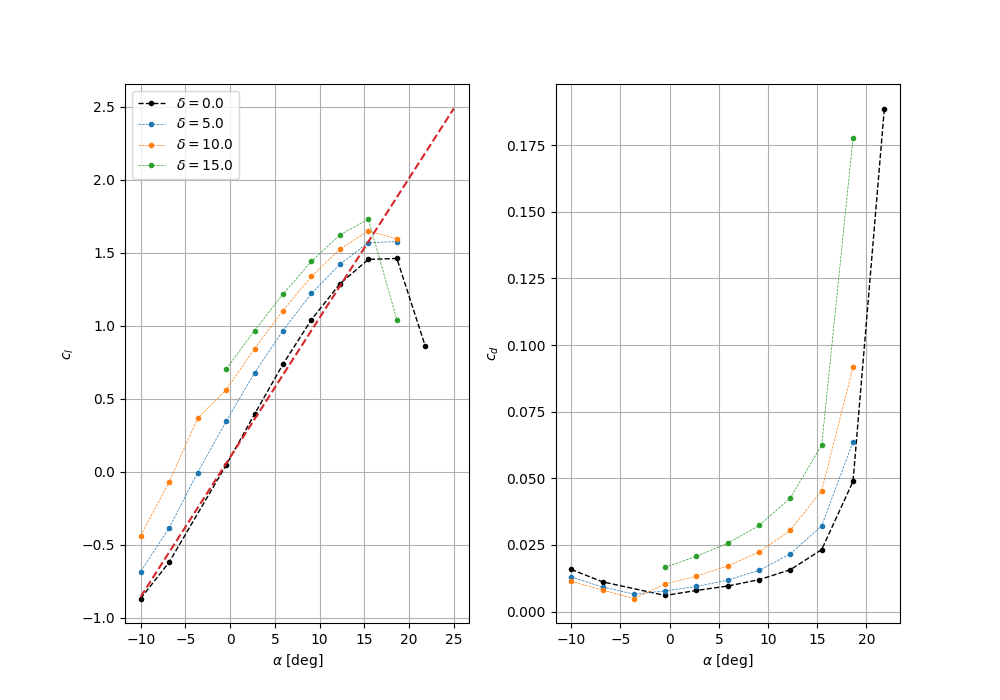

In [312]:
# LIFT
fig, ax = plt.subplots(1, 2, gridspec_kw={"wspace": 0.25})

color_exp = "black"

_deltas = list(results_per_delta.keys())[::2]

for delta in _deltas:

    # Unpack results
    _results = results_per_delta[delta]

    if _results.empty == True:
        continue

    if delta == 0:
        color = color_exp
        linewidth = 1.0
    else:
        color = None
        linewidth = 0.5

    # Lift polar
    ax[0].plot(
        _results["AOA"],
        _results["CL"],
        marker=".",
        linestyle="--",
        linewidth=linewidth,
        color=color,
        label=f"$\delta = {delta}$",
    )

    # Drag polar
    ax[1].plot(
        _results["AOA"],
        _results["CD"],
        marker=".",
        linestyle="--",
        linewidth=linewidth,
        color=color,
        label=f"$\delta = {delta}$",
    )
    
# Plot linear regression of base polar
cl_alpha = base_polar_data["slope"]
cl0 = base_polar_data["cl_zero"]

AOArange = np.linspace(AOA_START, AOA_END, num=AOA_N)
cl_alpha *= np.pi / 180
ax[0].plot(AOArange, cl_alpha * AOArange + cl0, "--")

ax[0].set_xlabel("$\\alpha$ [deg]")
ax[0].set_ylabel("$c_l$")
ax[0].legend()
ax[0].grid()

ax[1].set_xlabel("$\\alpha$ [deg]")
ax[1].set_ylabel("$c_d$")
ax[1].grid()

savefig(fname="lift_drag_polar_plain_flap.png")

The viscous calculations accurately predict the change in lift slope compared to the inviscid calculations. 
Applying the Mach corrections does result in a worse prediction compared to the incompressible calculation.
This seems to be in line with the results in [2], where the authors choose not to use a Mach correction for this case, but do use one for another case at the same Mach number.
In the following, the pressure distributions are compared to the incompressible calculations.

In [231]:
DISPLACEMENT = 1.0

# Shorthand for plotting all info for a single AOA from the csv dataset
def plot_cp_exp(ax, data, plot_transition=False):

    plotter_cp = partial(ax.plot, linestyle="None", color="tab:blue", marker="o")
    plotter_transition = partial(
        ax.plot,
        linestyle="None",
        color="tab:orange",
        marker="D",
    )

    plotter_cp(
        data["EXPMAINCP_X"],
        data["EXPMAINCP_Y"],
        label="Experiment",
    )
    plotter_cp(
        data["EXPFLAPCP_X"] + DISPLACEMENT,
        data["EXPFLAPCP_Y"],
    )

    if plot_transition == True:
        plotter_transition(
            data["EXPMAINTR_X"],
            data["EXPMAINTR_Y"],
            label="Experimental transition region",
        )
        plotter_transition(
            data["EXPFLAPTR_X"] + DISPLACEMENT,
            data["EXPFLAPTR_Y"],
        )


# Shorthand for plotting all info from the calculations for a single AOA
def plot_cp(ax, p, bl, label=None, plot_transition=False, disp_idx=None):

    # A helper index, cp is a single array of pressures over all panel nodes
    # IMF = [range(0, p.foils[0].N), range(p.foils[0].N, p.foils[0].N + p.foils[1].N)]
    IMF = [range(0, p.foils[0].N)]

    plotter_cp = partial(ax.plot, marker="None")
    plotter_tr = partial(ax.plot, color="tab:red", marker="v")

    if label is None:
        _label = "Original"
        linestyle = "-"
    else:
        _label = f"$\delta = {label}$"
        linestyle = "--"

    x_coords = np.array(p.foils[0].X[0, :])

    if disp_idx is None:
        _disp = 0.0
    else:
        _disp = DISPLACEMENT
    x_coords += _disp * disp_idx

    plotter_cp(x_coords, -p.cp[IMF[0]], label=_label, linestyle=linestyle)

    if plot_transition == True:
        # Small hack, only works for TWO elements
        for k in range(1):
            tr_lo = np.interp(
                bl[k].ST + bl[k].bl_fl.node_tr_lo.xi[0],
                p.foils[k].S,
                p.foils[k].X[0, :] + k * DISPLACEMENT,
            )
            tr_up = np.interp(
                bl[k].ST - bl[k].bl_fl.node_tr_up.xi[0],
                p.foils[k].S,
                p.foils[k].X[0, :] + k * DISPLACEMENT,
            )
            cp_up = np.interp(
                bl[k].ST - bl[k].bl_fl.node_tr_up.xi[0],
                p.foils[k].S,
                np.asarray(p.cp[IMF[k]]).ravel(),
            )
            cp_lo = np.interp(
                bl[k].ST + bl[k].bl_fl.node_tr_lo.xi[0],
                p.foils[k].S,
                np.asarray(p.cp[IMF[k]]).ravel(),
            )

            plotter_tr(tr_lo, -cp_lo, label="Numerical transition point")
            plotter_tr(tr_up, -cp_up)

<IPython.core.display.Javascript object>


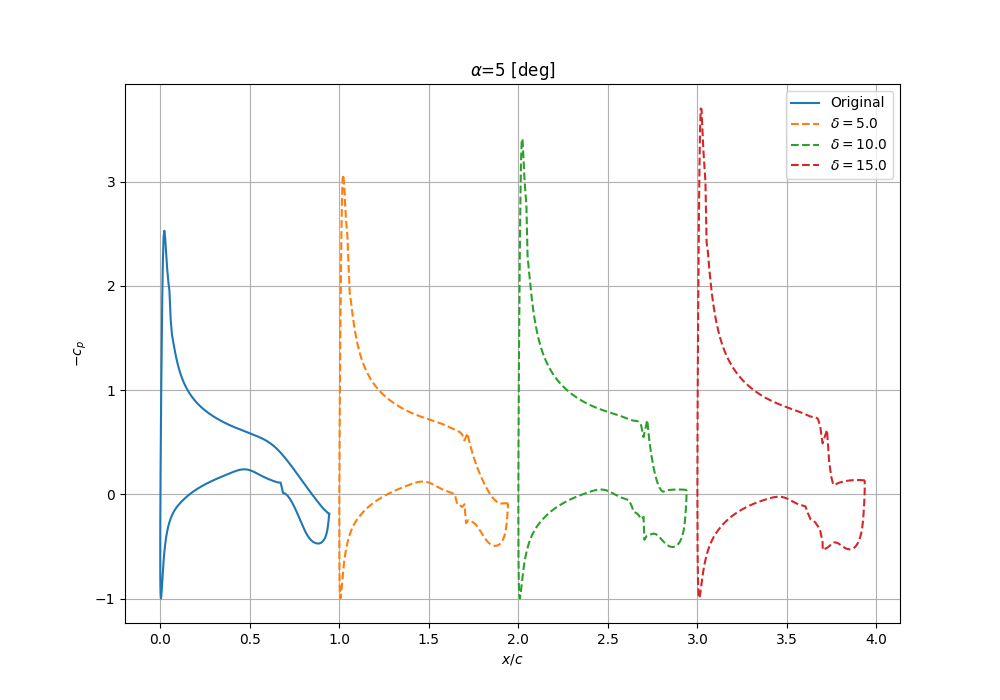

 xi=0.704338,delta=0.000028,theta=0.000019,ue=3.489964,typ=turbulent,
 res=[0.0132257,-0.202564,-2.71668e-06]
 dx=[-1.8035e-06,0.0284045,0.000934927]
 x=[1.92109e-05,3.48996,0.0148108] 
 lam=1.000000 H=1.458981 HS=1.783679 US=0.553811.

 xi=0.704654,delta=0.000039,theta=0.000025,ue=2.651383,typ=turbulent,
 res=[0.0361004,-0.318434,-7.1373e-06]
 dx=[-4.88004e-06,0.0506956,0.00207483]
 x=[2.49696e-05,2.65138,0.0193074] 
 lam=1.000000 H=1.571498 HS=1.747763 US=0.490990.

 xi=0.706852,delta=0.000060,theta=0.000043,ue=2.094574,typ=turbulent,
 res=[0.0106797,-0.248394,-4.12014e-05]
 dx=[-6.99603e-06,0.0536643,0.000626347]
 x=[4.28513e-05,2.09457,0.0231009] 
 lam=1.000000 H=1.398200 HS=1.804386 US=0.592627.



In [232]:
ALPHA = 5

fig, ax = plt.subplots(1, 1)

deltas = list(results_per_delta.keys())[::2]
displacements = range(len(deltas))

for delta, disp in zip(deltas, displacements):

    # Experiment and simulation
    _results, p, bl = simulate(main=MAIN, hinge=HINGE, delta=delta, alpha=ALPHA)

    if np.isclose(delta, 0.0):
        delta = None
        
    plot_cp(ax, p, bl, label=delta, disp_idx=disp)

    if delta is None:
        delta = 0
    _, hinge_point = create_plain_flap(
        hinge=HINGE,
        delta=delta,
        coordinates=MAIN,
        smooth_result=False,
    )

# ax.plot(hinge_point[0], hinge_point[1], marker = "o")
ax.set_xlabel("$x/c$")
ax.set_ylabel("$-c_p$")
ax.set_title(f"$\\alpha$={ALPHA} [deg]")
ax.legend()
ax.grid()

savefig("pressure_distribution_validation_plain_flap.png")

## Torenbeek method

In [283]:
def compute_alpha_delta(cf, c):

    theta_f = 2.0 * (cf / c) - 1.0
    theta_f = np.arccos(theta_f)

    alpha_delta = 1.0 - (theta_f - np.sin(theta_f)) / np.pi

    return alpha_delta

In [347]:
ETA = pd.read_csv(filepath_or_buffer = "eta_plain_flap.csv")

In [348]:
def compute_eta_factor(delta):

    values = ETA.values.T
    x = values[0, :]
    y = values[1, :]

    f = interp1d(x=x, y=y)
    
    eta = f(delta)

    return eta

In [337]:
c = MAIN[0,:].max()
cf = c - HINGE

In [376]:
def _torenbeek_prediction(cf, c, cl_alpha, delta, use_eta=True):

    delta = np.deg2rad(delta)
    
    if use_eta == True:
        factor = compute_eta_factor(delta)
    else:
        factor = 1.0

    alpha_delta = compute_alpha_delta(cf=cf, c=c)

    prediction = factor * alpha_delta * cl_alpha * delta

    return prediction

In [354]:
cl_alpha = base_polar_data["slope"]
cl0 = base_polar_data["cl_zero"]
cl_alpha, cl0

(5.476, 0.1)

In [357]:
prediction = []
_appender = prediction.append

_deltas = torenbeek_df.index

_predictor = partial(
    _torenbeek_prediction,
    cf=cf,
    c=c,
    cl_alpha=cl_alpha,
)

for delta in _deltas:

    increment = _predictor(delta=delta, use_eta=False)
    increment_eta = _predictor(delta=delta, use_eta=True)

    _appender((delta, increment, increment_eta))

prediction_df = (
    pd.DataFrame(prediction, columns=["delta", "Theory", "Corrected"]).set_index("delta").squeeze()
)
prediction_df += cl0

<IPython.core.display.Javascript object>


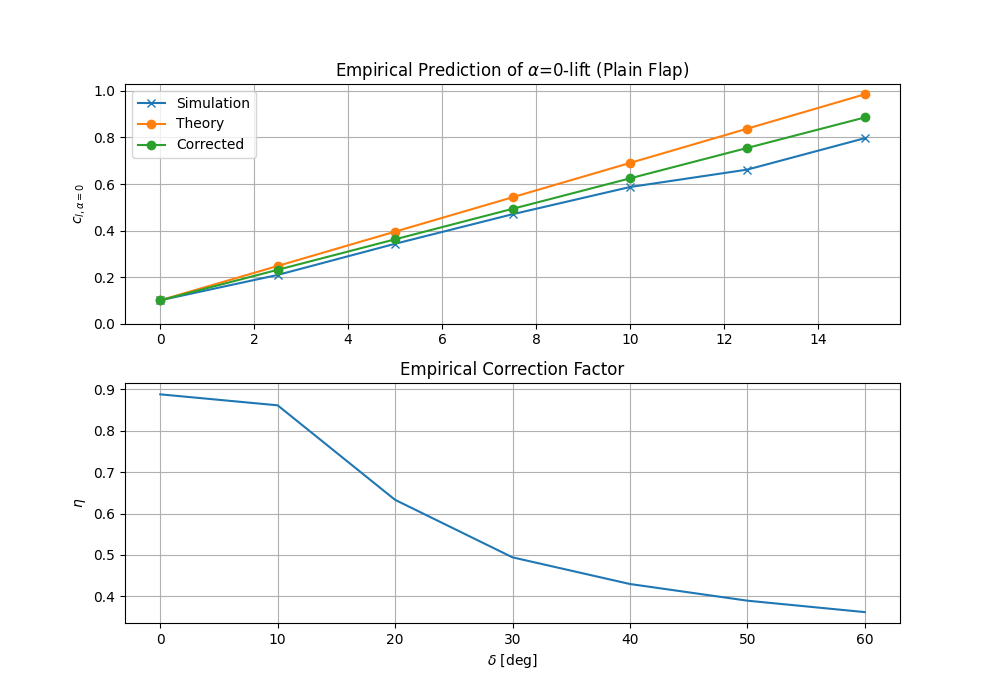

In [377]:
fig, ax = plt.subplots(2, 1, gridspec_kw={"hspace": 0.25})
series = torenbeek_df["cl_zero"]
series.name = "Simulation"
series.plot(marker="x", ax=ax[0])
prediction_df.plot(marker="o", ax=ax[0])
ax[0].grid()
ax[0].legend()
ax[0].set_title("Empirical Prediction of $\\alpha$=0-lift (Plain Flap)")
ax[0].set_xlabel("")
ax[0].set_ylabel("$c_{l,\\alpha=0}$")
ax[0].set_ylim(0.0)

ETA.set_index("delta").plot(ax=ax[1], grid=True, legend=False)
ax[1].set_ylabel("$\eta$")
ax[1].set_xlabel("$\delta$ [deg]")
ax[1].set_title("Empirical Correction Factor")

savefig("zero_aoa_lift_prediction.png")

## Load distribution

<IPython.core.display.Javascript object>


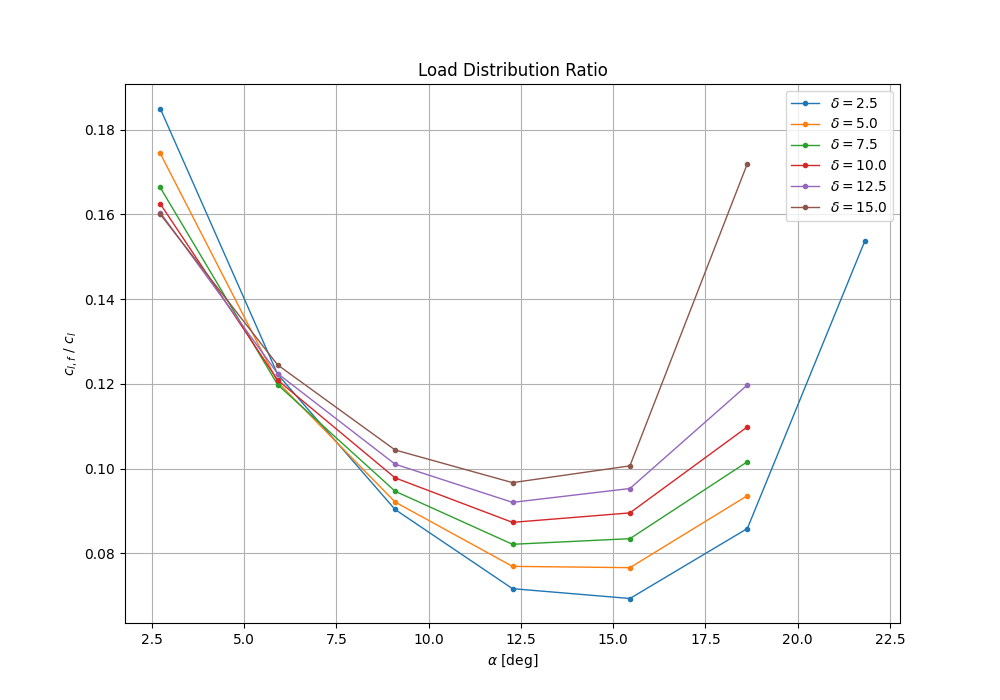

In [334]:
# LIFT
fig, ax = plt.subplots(1, 1)

color_exp = "black"

_deltas = list(results_per_delta.keys())

for delta in _deltas:

    # Unpack results
    _results = results_per_delta[delta].copy()
    # Filter results
    mask_error = _results["CL_error"].abs() < 0.1
    mask_alpha = _results["AOA"] > 0.0
    mask = mask_error & mask_alpha
    _results = _results.loc[mask]

    if _results.empty == True:
        continue

    if delta == 0.0:
        continue
        #color = color_exp
        #linewidth = 1.0
    else:
        color = None
        linewidth = 1.0

    # Lift polar
    ax.plot(
        _results["AOA"],
        _results["load_ratio"],
        marker=".",
        linestyle="-",
        linewidth=linewidth,
        color=color,
        label=f"$\delta = {delta}$",
    )

ax.set_xlabel("$\\alpha$ [deg]")
ax.set_ylabel("$c_{l,f}$ / $c_{l}$")
ax.legend()
ax.grid()
ax.set_title("Load Distribution Ratio")

savefig(fname="load_distribution_plain_flap.png")

[1] B. van den Berg and B. Oskam. *Boundary layer measurements on a two-dimensional wing with flap and a comparison with calculations.* NLR MP 79034 U

[2] Cebeci, Tuncer, Eric Besnard, and Hsun Chen. *Calculation of multielement airfoil flows, including flap wells.* 34th Aerospace Sciences Meeting and Exhibit. 1996.

[3] Schwamborn, Dieter, et al. *Development of the DLR tau-code for aerospace applications.* Proceedings of the International Conference on Aerospace Science and Technology. Bangalore, India: National Aerospace Laboratories, 2008.

[4] Guo, Chuanliang. *Effects of turbulence modelling on the analysis and optimisation of high-lift configurations.* Master Thesis, Cranfield University

[5] Van Ingen, J. L. *The eN method for transition prediction: historical review of work at TU Delft.* AIAA, 2008.

[6] Godin, P., D. W. Zingg, and T. E. Nelson. *High-lift aerodynamic computations with one-and two-equation turbulence models.* AIAA journal 35.2 (1997): 237-243.

[7] Haase, W. et al. *ECARP - European Computational Aerodynamics Research Projects: Validation of CFD Codes and Assessment of Turbulence Models.* Notes on Numerical Fluid Mechanics, Vol. 58, 1997. 